In [1]:
import numpy as np
import torch

# initialize the RNG deterministically
np.random.seed(42)
torch.manual_seed(42)
torch.set_float32_matmul_precision('medium')

In [2]:
# parameters
dataset_name = ""
model_name = "flow_ss_vcr_mse"
ood = ""

In [3]:
# Parameters
dataset_name = "rbc_phase"
ood = "1"


In [4]:
# initialize data attributes and loaders
from config import load_config

config = load_config(
    dataset_name = dataset_name,
    model_name = model_name,
    ood = ood,
)
config.load_data()
config.print_labels()
dm = config.datamodule

assert dm

In [5]:
dm.setup("fit")
dm.setup("test")
dm.setup("predict")

RBC Dataset V.2 => All pateints
Dataset split type train, image type: phase


Loaded 1462 images
RBC Dataset V.2 => All pateints
Dataset split type val, image type: phase


Loaded 493 images
RBC Dataset V.2 => All pateints
Dataset split type test, image type: phase


Loaded 493 images
RBC Dataset V.2 => All pateints
Dataset split type test, image type: phase


Loaded 928 images


In [6]:
# model ids
import pandas as pd
ood_str = ":".join(map(str, config.ood))
df = pd.read_csv("ids.csv").fillna("")
model_id = df[(df.dataset_name == dataset_name) & (df.model_name == model_name) & (df.ood == ood)].id.item()
print(ood_str, model_id)

1 duvrach6


In [7]:
model = config.get_model()

In [8]:
from pathlib import Path
from lightning.pytorch.loggers.wandb import WandbLogger

artifact_dir = WandbLogger.download_artifact(artifact=f"yasith/robustml/model-{model_id}:best")
model = model.__class__.load_from_checkpoint(Path(artifact_dir) / "model.ckpt", config=config)
model = model.cuda()
model.eval();

wandb:   1 of 1 files downloaded.  


In [9]:
train_loader = dm.train_dataloader()
val_loader = dm.val_dataloader()
test_loader = dm.test_dataloader()
if ood_str:
    predict_loader = dm.predict_dataloader()

In [10]:
from tqdm import tqdm

trn_inp = []
trn_e_u = []
trn_e_v = []
trn_rcn = []
trn_tgt = []

val_inp = []
val_e_u = []
val_e_v = []
val_rcn = []
val_tgt = []

ind_inp = []
ind_e_u = []
ind_e_v = []
ind_rcn = []
ind_tgt = []

if ood_str:
    ood_inp = []
    ood_e_u = []
    ood_e_v = []
    ood_rcn = []
    ood_tgt = []

rnd_inp = []
rnd_e_u = []
rnd_e_v = []
rnd_rcn = []

# train set (ind)
for batch_idx, batch in enumerate(tqdm(train_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    trn_inp.extend(x.detach().cpu().numpy())
    trn_e_u.extend(e_u.detach().cpu().numpy())
    trn_e_v.extend(e_v.detach().cpu().numpy())
    trn_rcn.extend(rcn.detach().cpu().numpy())
    trn_tgt.extend(y.detach().cpu().numpy())
print("train - OK")

# val set (ind)
for batch_idx, batch in enumerate(tqdm(val_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    val_inp.extend(x.detach().cpu().numpy())
    val_e_u.extend(e_u.detach().cpu().numpy())
    val_e_v.extend(e_v.detach().cpu().numpy())
    val_rcn.extend(rcn.detach().cpu().numpy())
    val_tgt.extend(y.detach().cpu().numpy())
print("val - OK")

# test set (ind)
for batch_idx, batch in enumerate(tqdm(test_loader)):
    x, y, *_ = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    ind_inp.extend(x.detach().cpu().numpy())
    ind_e_u.extend(e_u.detach().cpu().numpy())
    ind_e_v.extend(e_v.detach().cpu().numpy())
    ind_rcn.extend(rcn.detach().cpu().numpy())
    ind_tgt.extend(y.detach().cpu().numpy())
print("test InD - OK")

# predict set (ood)
if ood_str:
    for batch_idx, batch in enumerate(tqdm(predict_loader)):
        x, y, *_ = batch
        x = x.float().cuda()
        (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
        ood_inp.extend(x.detach().cpu().numpy())
        ood_e_u.extend(e_u.detach().cpu().numpy())
        ood_e_v.extend(e_v.detach().cpu().numpy())
        ood_rcn.extend(rcn.detach().cpu().numpy())
        ood_tgt.extend(y.detach().cpu().numpy())
    print("test OoD - OK")

# random set
rnd_set = torch.randn(100, config.batch_size, *config.input_shape)
for batch_idx, batch in enumerate(tqdm(rnd_set)):
    x = batch
    x = x.float().cuda()
    (e_u, e_v), (n_u, n_v), rcn, _ = model(x)
    rnd_inp.extend(x.detach().cpu().numpy())
    rnd_e_u.extend(e_u.detach().cpu().numpy())
    rnd_e_v.extend(e_v.detach().cpu().numpy())
    rnd_rcn.extend(rcn.detach().cpu().numpy())
print("test RnD - OK")

  0%|                                                                                                                                              | 0/23 [00:00<?, ?it/s]

  4%|█████▊                                                                                                                                | 1/23 [00:00<00:16,  1.35it/s]

 13%|█████████████████▍                                                                                                                    | 3/23 [00:00<00:04,  4.34it/s]

 22%|█████████████████████████████▏                                                                                                        | 5/23 [00:00<00:02,  7.26it/s]

 30%|████████████████████████████████████████▊                                                                                             | 7/23 [00:01<00:01,  9.92it/s]

 39%|████████████████████████████████████████████████████▍                                                                                 | 9/23 [00:01<00:01, 12.21it/s]

 48%|███████████████████████████████████████████████████████████████▌                                                                     | 11/23 [00:01<00:00, 14.09it/s]

 57%|███████████████████████████████████████████████████████████████████████████▏                                                         | 13/23 [00:01<00:00, 15.58it/s]

 65%|██████████████████████████████████████████████████████████████████████████████████████▋                                              | 15/23 [00:01<00:00, 16.73it/s]

 74%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                  | 17/23 [00:01<00:00, 17.62it/s]

 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                       | 19/23 [00:01<00:00, 18.27it/s]

 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏     | 22/23 [00:01<00:00, 18.94it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 23/23 [00:01<00:00, 12.11it/s]

train - OK


  0%|                                                                                                                                               | 0/8 [00:00<?, ?it/s]

 12%|████████████████▉                                                                                                                      | 1/8 [00:00<00:01,  4.50it/s]

 38%|██████████████████████████████████████████████████▋                                                                                    | 3/8 [00:00<00:00, 10.41it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▍                                                  | 5/8 [00:00<00:00, 13.72it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 7/8 [00:00<00:00, 15.78it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 12.70it/s]

val - OK


  0%|                                                                                                                                               | 0/8 [00:00<?, ?it/s]

 12%|████████████████▉                                                                                                                      | 1/8 [00:00<00:01,  4.41it/s]

 38%|██████████████████████████████████████████████████▋                                                                                    | 3/8 [00:00<00:00, 10.27it/s]

 62%|████████████████████████████████████████████████████████████████████████████████████▍                                                  | 5/8 [00:00<00:00, 13.62it/s]

 88%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                | 7/8 [00:00<00:00, 15.70it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 13.21it/s]

test InD - OK


  0%|                                                                                                                                              | 0/15 [00:00<?, ?it/s]

  7%|████████▉                                                                                                                             | 1/15 [00:00<00:03,  4.36it/s]

 20%|██████████████████████████▊                                                                                                           | 3/15 [00:00<00:01, 10.24it/s]

 33%|████████████████████████████████████████████▋                                                                                         | 5/15 [00:00<00:00, 13.56it/s]

 47%|██████████████████████████████████████████████████████████████▌                                                                       | 7/15 [00:00<00:00, 15.60it/s]

 60%|████████████████████████████████████████████████████████████████████████████████▍                                                     | 9/15 [00:00<00:00, 16.98it/s]

 73%|█████████████████████████████████████████████████████████████████████████████████████████████████▌                                   | 11/15 [00:00<00:00, 17.87it/s]

 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                 | 13/15 [00:00<00:00, 18.50it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 18.04it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 15/15 [00:00<00:00, 15.20it/s]

test OoD - OK


  0%|                                                                                                                                             | 0/100 [00:00<?, ?it/s]

  3%|███▉                                                                                                                                 | 3/100 [00:00<00:04, 21.56it/s]

  6%|███████▉                                                                                                                             | 6/100 [00:00<00:04, 21.79it/s]

  9%|███████████▉                                                                                                                         | 9/100 [00:00<00:04, 21.87it/s]

 12%|███████████████▊                                                                                                                    | 12/100 [00:00<00:04, 21.90it/s]

 15%|███████████████████▊                                                                                                                | 15/100 [00:00<00:03, 21.91it/s]

 18%|███████████████████████▊                                                                                                            | 18/100 [00:00<00:03, 21.92it/s]

 21%|███████████████████████████▋                                                                                                        | 21/100 [00:00<00:03, 21.92it/s]

 24%|███████████████████████████████▋                                                                                                    | 24/100 [00:01<00:03, 21.91it/s]

 27%|███████████████████████████████████▋                                                                                                | 27/100 [00:01<00:03, 21.90it/s]

 30%|███████████████████████████████████████▌                                                                                            | 30/100 [00:01<00:03, 21.92it/s]

 33%|███████████████████████████████████████████▌                                                                                        | 33/100 [00:01<00:03, 21.93it/s]

 36%|███████████████████████████████████████████████▌                                                                                    | 36/100 [00:01<00:02, 21.94it/s]

 39%|███████████████████████████████████████████████████▍                                                                                | 39/100 [00:01<00:02, 21.94it/s]

 42%|███████████████████████████████████████████████████████▍                                                                            | 42/100 [00:01<00:02, 21.94it/s]

 45%|███████████████████████████████████████████████████████████▍                                                                        | 45/100 [00:02<00:02, 21.94it/s]

 48%|███████████████████████████████████████████████████████████████▎                                                                    | 48/100 [00:02<00:02, 21.94it/s]

 51%|███████████████████████████████████████████████████████████████████▎                                                                | 51/100 [00:02<00:02, 21.94it/s]

 54%|███████████████████████████████████████████████████████████████████████▎                                                            | 54/100 [00:02<00:02, 21.93it/s]

 57%|███████████████████████████████████████████████████████████████████████████▏                                                        | 57/100 [00:02<00:01, 21.93it/s]

 60%|███████████████████████████████████████████████████████████████████████████████▏                                                    | 60/100 [00:02<00:01, 21.93it/s]

 63%|███████████████████████████████████████████████████████████████████████████████████▏                                                | 63/100 [00:02<00:01, 21.93it/s]

 66%|███████████████████████████████████████████████████████████████████████████████████████                                             | 66/100 [00:03<00:01, 21.93it/s]

 69%|███████████████████████████████████████████████████████████████████████████████████████████                                         | 69/100 [00:03<00:01, 21.93it/s]

 72%|███████████████████████████████████████████████████████████████████████████████████████████████                                     | 72/100 [00:03<00:01, 21.93it/s]

 75%|███████████████████████████████████████████████████████████████████████████████████████████████████                                 | 75/100 [00:03<00:01, 21.92it/s]

 78%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                             | 78/100 [00:03<00:01, 21.92it/s]

 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████▉                         | 81/100 [00:03<00:00, 21.92it/s]

 84%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                     | 84/100 [00:03<00:00, 21.91it/s]

 87%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 87/100 [00:03<00:00, 21.91it/s]

 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊             | 90/100 [00:04<00:00, 21.90it/s]

 93%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 93/100 [00:04<00:00, 21.91it/s]

 96%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋     | 96/100 [00:04<00:00, 21.92it/s]

 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋ | 99/100 [00:04<00:00, 21.92it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 21.91it/s]

test RnD - OK


In [11]:
trn_inp = np.array(trn_inp)
trn_e_u = np.array(trn_e_u).squeeze()
trn_e_v = np.array(trn_e_v).squeeze()
trn_rcn = np.array(trn_rcn)
trn_tgt = np.array(trn_tgt)

val_inp = np.array(val_inp)
val_e_u = np.array(val_e_u).squeeze()
val_e_v = np.array(val_e_v).squeeze()
val_rcn = np.array(val_rcn)
val_tgt = np.array(val_tgt)

ind_inp = np.array(ind_inp)
ind_e_u = np.array(ind_e_u).squeeze()
ind_e_v = np.array(ind_e_v).squeeze()
ind_rcn = np.array(ind_rcn)
ind_tgt = np.array(ind_tgt)

if ood_str:
    ood_inp = np.array(ood_inp)
    ood_e_u = np.array(ood_e_u).squeeze()
    ood_e_v = np.array(ood_e_v).squeeze()
    ood_rcn = np.array(ood_rcn)
    ood_tgt = np.array(ood_tgt)

rnd_inp = np.array(rnd_inp)
rnd_e_u = np.array(rnd_e_u).squeeze()
rnd_e_v = np.array(rnd_e_v).squeeze()
rnd_rcn = np.array(rnd_rcn)

print(trn_inp.shape, trn_e_u.shape, trn_e_v.shape, trn_rcn.shape, trn_tgt.shape)
print(val_inp.shape, val_e_u.shape, val_e_v.shape, val_rcn.shape, val_tgt.shape)
print(ind_inp.shape, ind_e_u.shape, ind_e_v.shape, ind_rcn.shape, ind_tgt.shape)
if ood_str:
    print(ood_inp.shape, ood_e_u.shape, ood_e_v.shape, ood_rcn.shape, ood_tgt.shape)
print(rnd_inp.shape, rnd_e_u.shape, rnd_e_v.shape, rnd_rcn.shape)

(1462, 1, 64, 64) (1462, 512) (1462, 3584) (1462, 1, 64, 64) (1462,)
(493, 1, 64, 64) (493, 512) (493, 3584) (493, 1, 64, 64) (493,)
(493, 1, 64, 64) (493, 512) (493, 3584) (493, 1, 64, 64) (493,)
(928, 1, 64, 64) (928, 512) (928, 3584) (928, 1, 64, 64) (928,)
(6400, 1, 64, 64) (6400, 512) (6400, 3584) (6400, 1, 64, 64)


In [12]:
from tsnecuda import TSNE

n = ind_inp.shape[0]

if ood_str:
    all_e_u = np.concatenate([ind_e_u, ood_e_u], axis=0)
    all_e_v = np.concatenate([ind_e_v, ood_e_v], axis=0)
else:
    all_e_u = ind_e_u
    all_e_v = ind_e_v

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_u2d = tsne.fit_transform(all_e_u)
ind_e_u2d = np.array(e_u2d[:n], order='C').astype(np.float32)
ood_e_u2d = np.array(e_u2d[n:], order='C').astype(np.float32)
print(ind_e_u2d.shape, ood_e_u2d.shape)

tsne = TSNE(n_components=2, perplexity=1000, random_seed=42)
e_v2d = tsne.fit_transform(all_e_v)
ind_e_v2d = np.array(e_v2d[:n], order='C').astype(np.float32)
ood_e_v2d = np.array(e_v2d[n:], order='C').astype(np.float32)
print(ind_e_v2d.shape, ood_e_v2d.shape)

WARNING clustering 1421 points to 37 centroids: please provide at least 1443 training points


(493, 2) (928, 2)


WARNING clustering 1421 points to 37 centroids: please provide at least 1443 training points


(493, 2) (928, 2)


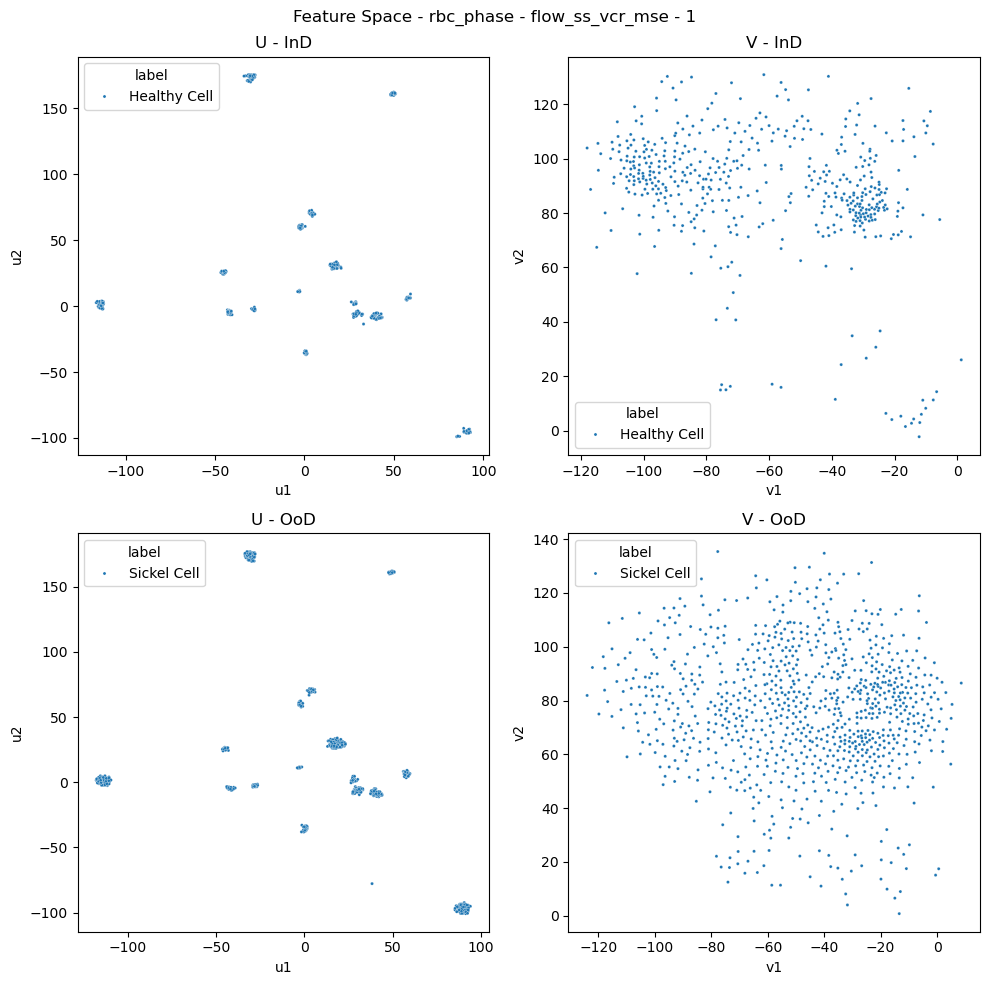

In [13]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

ind_labels = [config.labels[i] for i in ind_tgt]
emb_data = pd.DataFrame()
u1, u2 = ind_e_u2d.T
v1, v2 = ind_e_v2d.T
emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ind_labels, source="ind"))])

if ood_str:
    ood_labels = [config.labels[i] for i in ood_tgt]
    u1, u2 = ood_e_u2d.T
    v1, v2 = ood_e_v2d.T
    emb_data = pd.concat([emb_data, pd.DataFrame(dict(u1=u1, u2=u2, v1=v1, v2=v2, label=ood_labels, source="ood"))])

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(10, 10))

fig.suptitle(f"Feature Space - {dataset_name} - {model_name} - {ood_str}")
ax1.set_title("U - InD")
ax2.set_title("V - InD")
ax3.set_title("U - OoD")
ax4.set_title("V - OoD")

sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="u1", y="u2", hue="label", s=5, ax=ax1)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ind")], x="v1", y="v2", hue="label", s=5, ax=ax2)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="u1", y="u2", hue="label", s=5, ax=ax3)
sns.scatterplot(data=emb_data[(emb_data['source'] == "ood")], x="v1", y="v2", hue="label", s=5, ax=ax4)

plt.tight_layout()
plt.show()

  0%|                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████▊                                                                                                     | 1/4 [00:00<00:00,  8.26it/s]

 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 2/4 [00:00<00:00,  4.83it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3/4 [00:00<00:00,  5.94it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.61it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.29it/s]

  0%|                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████▊                                                                                                     | 1/4 [00:00<00:00,  6.39it/s]

 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 2/4 [00:00<00:00,  6.44it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3/4 [00:00<00:00,  6.40it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  6.35it/s]

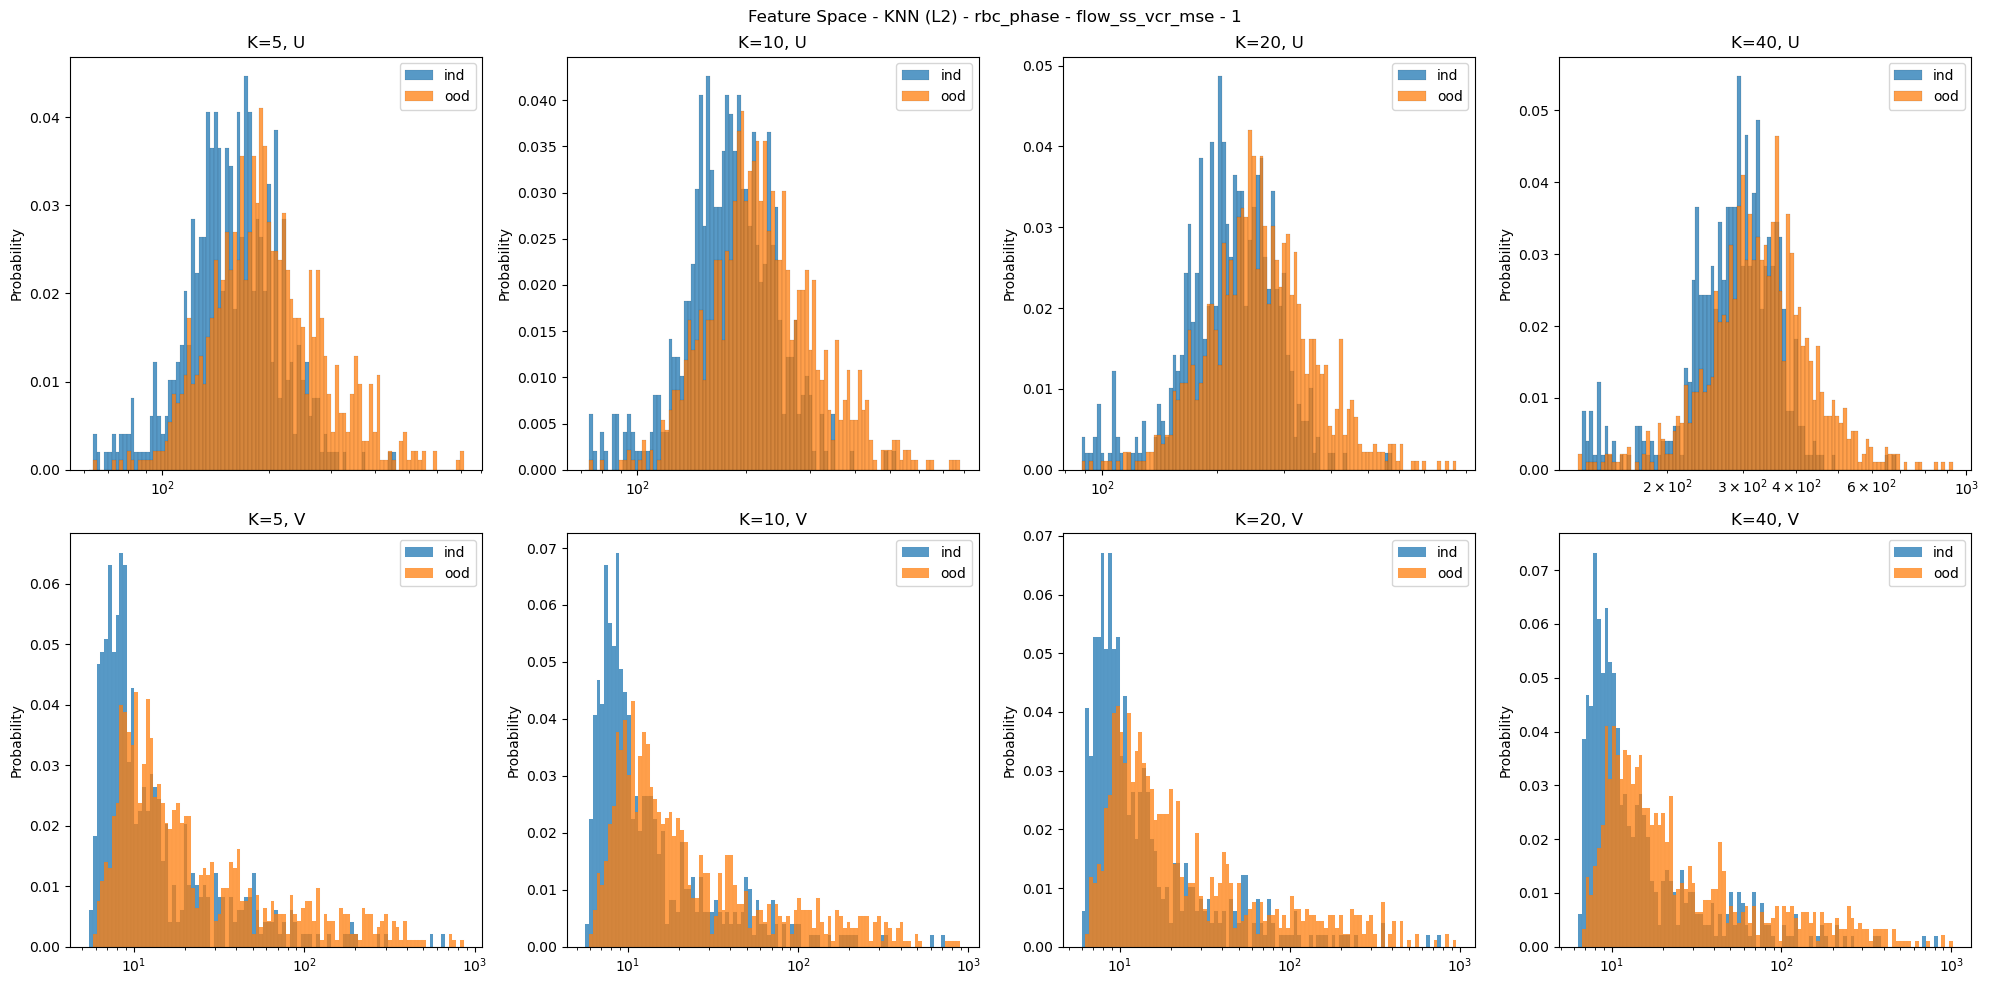

In [14]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (L2) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatL2(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatL2(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

  0%|                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████▊                                                                                                     | 1/4 [00:00<00:00,  8.32it/s]

 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 2/4 [00:00<00:00,  8.40it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3/4 [00:00<00:00,  8.27it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.16it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  8.21it/s]

  0%|                                                                                                                                               | 0/4 [00:00<?, ?it/s]

 25%|█████████████████████████████████▊                                                                                                     | 1/4 [00:00<00:00,  6.68it/s]

 50%|███████████████████████████████████████████████████████████████████▌                                                                   | 2/4 [00:00<00:00,  6.60it/s]

 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████▎                                 | 3/4 [00:00<00:00,  6.57it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.32it/s]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:00<00:00,  4.95it/s]

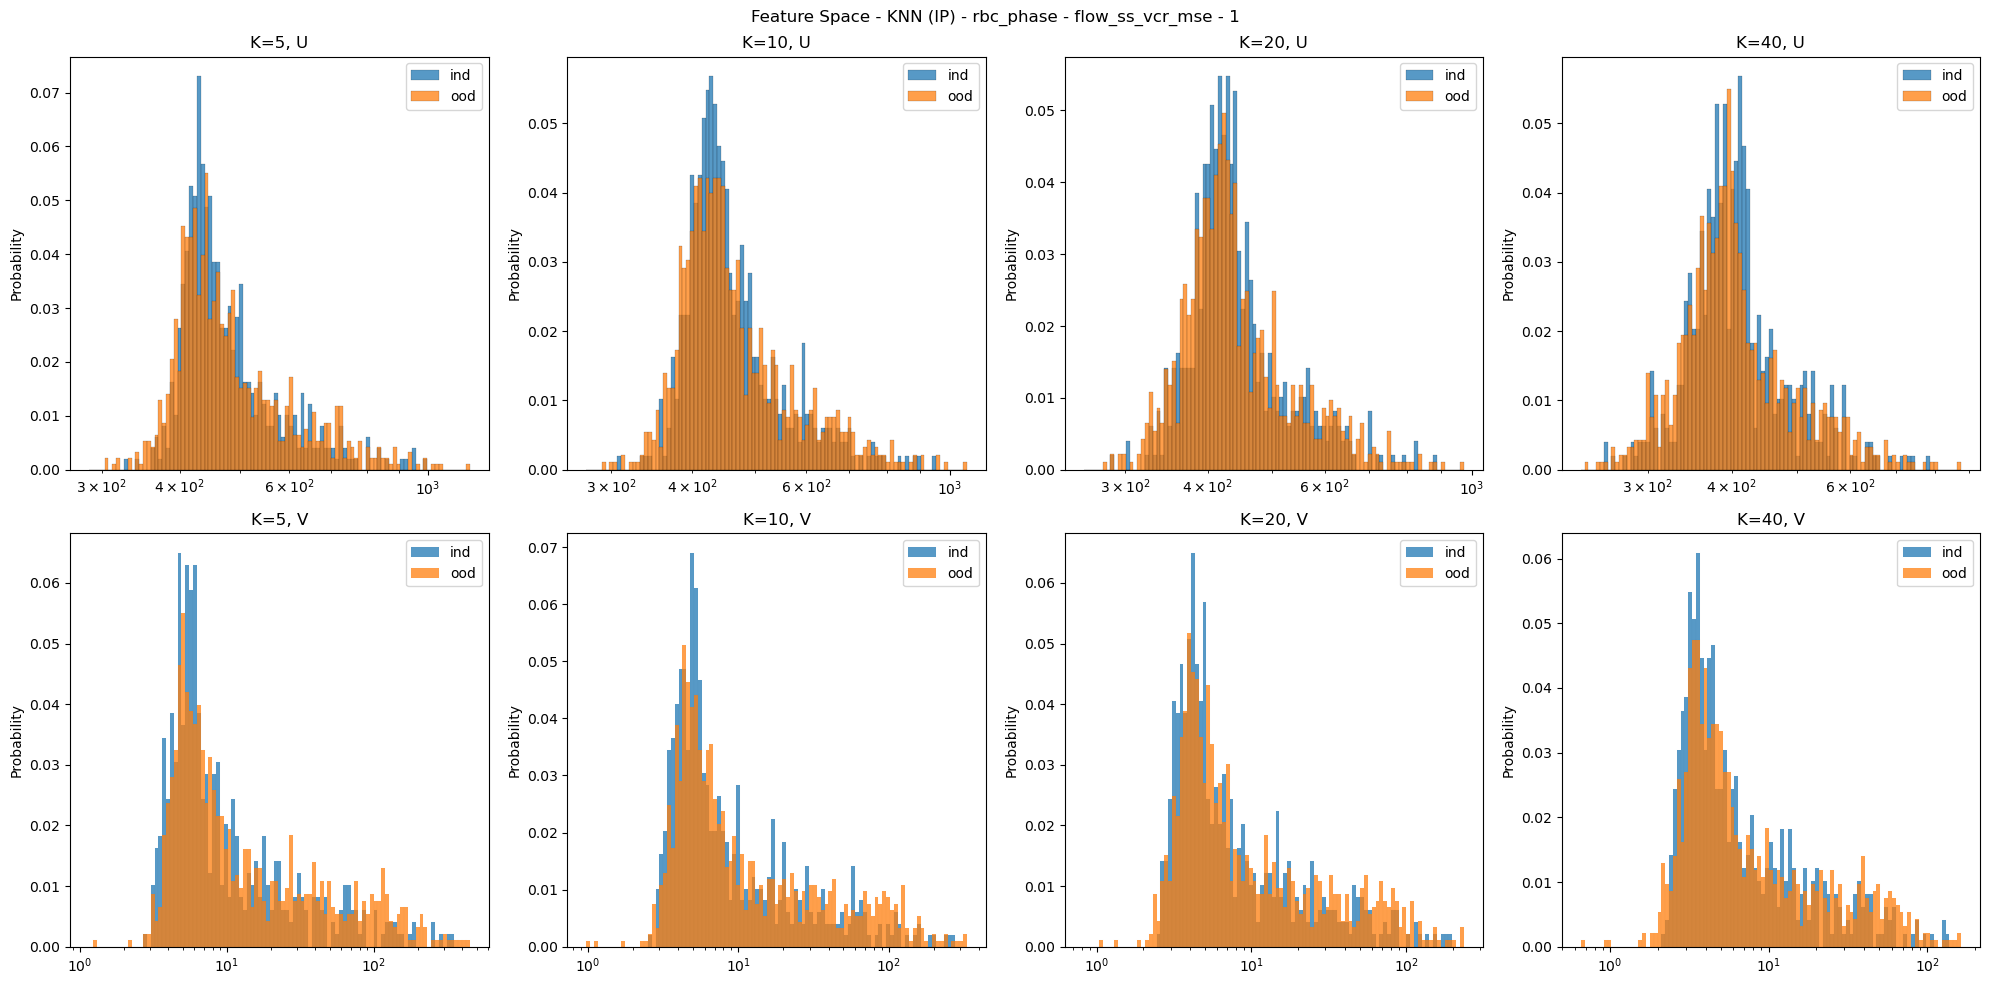

In [15]:
import faiss

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
fig.suptitle(f"Feature Space - KNN (IP) - {dataset_name} - {model_name} - {ood_str}")

index_e_u = faiss.IndexFlatIP(ind_e_u.shape[-1])
index_e_u.add(ind_e_u)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_u.search(ind_e_u, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_u.search(ood_e_u, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[0][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, U")
    ax.set_xscale('log')
    ax.legend()

index_e_v = faiss.IndexFlatIP(ind_e_v.shape[-1])
index_e_v.add(ind_e_v)
for j, k in enumerate(tqdm([5, 10, 20, 40])):
    Di = index_e_v.search(ind_e_v, k+1)[0][:, -k:].mean(-1) # avoid closest neighbor (itself)
    D = [Di]
    if ood_str:
        Do = index_e_v.search(ood_e_v, k)[0].mean(-1)
        D.append(Do)
    D = np.concatenate(D, axis=0)
    bins = np.logspace(np.log10(D.min()), np.log10(D.max()), 100)
    ax = axs[1][j]
    sns.histplot(Di, fill=True, label='ind', stat='probability', ax=ax, bins=bins)
    if ood_str:
        sns.histplot(Do, fill=True, label='ood', stat='probability', ax=ax, bins=bins)
    ax.set_title(f"K={k}, V")
    ax.set_xscale('log')
    ax.legend()

plt.tight_layout()
plt.show()

In [16]:
from scipy.linalg import norm

trn_n_u = norm(trn_e_u, axis=-1)
trn_n_v = norm(trn_e_v, axis=-1)
val_n_u = norm(val_e_u, axis=-1)
val_n_v = norm(val_e_v, axis=-1)
ind_n_u = norm(ind_e_u, axis=-1)
ind_n_v = norm(ind_e_v, axis=-1)
if ood_str:
    ood_n_u = norm(ood_e_u, axis=-1)
    ood_n_v = norm(ood_e_v, axis=-1)
rnd_n_u = norm(rnd_e_u, axis=-1)
rnd_n_v = norm(rnd_e_v, axis=-1)

print(trn_n_u.mean(), trn_n_u.std(), trn_n_v.mean(), trn_n_v.std())
print(val_n_u.mean(), val_n_u.std(), val_n_v.mean(), val_n_v.std())
print(ind_n_u.mean(), ind_n_u.std(), ind_n_v.mean(), ind_n_v.std())
if ood_str:
    print(ood_n_u.mean(), ood_n_u.std(), ood_n_v.mean(), ood_n_v.std())
print(rnd_n_u.mean(), rnd_n_u.std(), rnd_n_v.mean(), rnd_n_v.std())

23.508972 2.229889 4.2617626 3.4164522
23.351856 1.6673871 4.14872 2.6283896
23.460848 1.987464 4.1945243 3.1118016
24.260803 2.8787017 5.859041 4.5861225
31.682304 0.7787623 58.347363 0.7143868


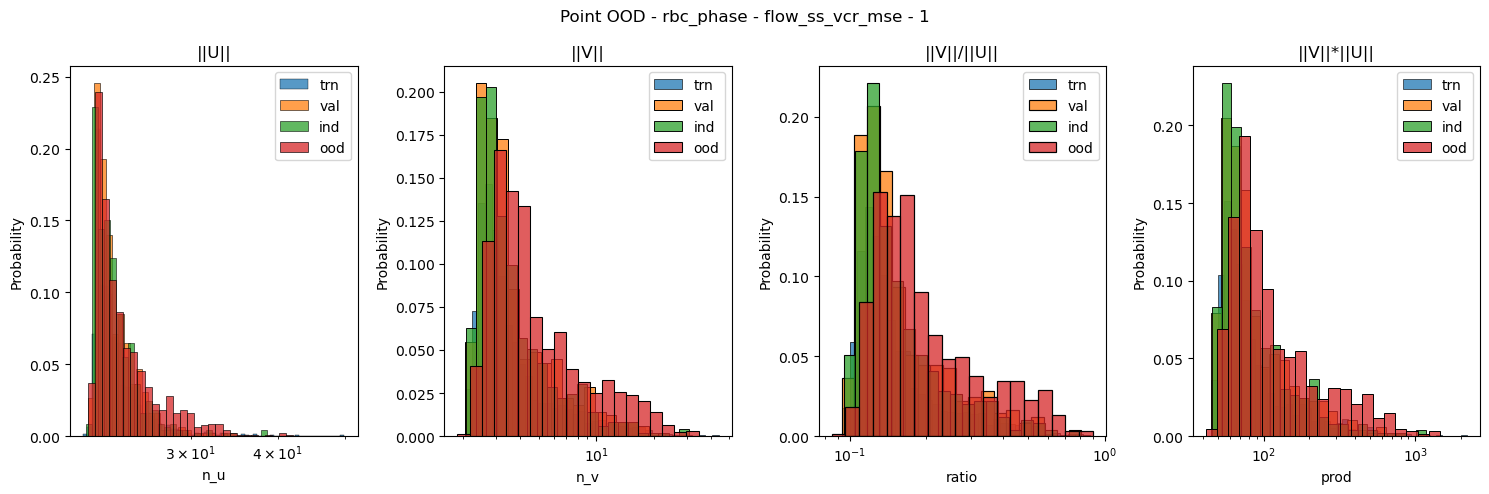

In [17]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

df_trn = pd.DataFrame(dict(n_u=trn_n_u, n_v=trn_n_v, ratio=trn_n_v/trn_n_u, prod=trn_n_v*trn_n_u, target=trn_tgt))
df_val = pd.DataFrame(dict(n_u=val_n_u, n_v=val_n_v, ratio=val_n_v/val_n_u, prod=val_n_v*val_n_u, target=val_tgt))
df_ind = pd.DataFrame(dict(n_u=ind_n_u, n_v=ind_n_v, ratio=ind_n_v/ind_n_u, prod=ind_n_v*ind_n_u, target=ind_tgt))
if ood_str:
    df_ood = pd.DataFrame(dict(n_u=ood_n_u, n_v=ood_n_v, ratio=ood_n_v/ood_n_u, prod=ood_n_v*ood_n_u, target=ood_tgt))
df_rnd = pd.DataFrame(dict(n_u=rnd_n_u, n_v=rnd_n_v, ratio=rnd_n_v/rnd_n_u, prod=rnd_n_v*rnd_n_u))

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 5))
fig.suptitle(f"Point OOD - {dataset_name} - {model_name} - {ood_str}")

def plot_row(prop, ax):
    sns.histplot(data=df_trn, x=prop, log_scale=True, fill=True, label='trn', stat='probability', ax=ax)
    sns.histplot(data=df_val, x=prop, log_scale=True, fill=True, label='val', stat='probability', ax=ax)
    sns.histplot(data=df_ind, x=prop, log_scale=True, fill=True, label='ind', stat='probability', ax=ax)
    if ood_str:
        sns.histplot(data=df_ood, x=prop, log_scale=True, fill=True, label='ood', stat='probability', ax=ax)
    # sns.histplot(data=df_rnd, x=prop, log_scale=True, fill=True, label='rnd', stat='density', ax=ax)
    ax.legend()

plot_row("n_u", ax1)
plot_row("n_v", ax2)
plot_row("ratio", ax3)
plot_row("prod", ax4)
ax1.title.set_text('||U||')
ax2.title.set_text('||V||')
ax3.title.set_text('||V||/||U||')
ax4.title.set_text('||V||*||U||')

plt.tight_layout()
plt.show()

In [18]:
if ood_str:
    df_tst = pd.concat([df_ind, df_ood], axis=0)
else:
    df_tst = df_ind

all_targets = list(df_tst['target'].unique())
K = len(all_targets)
N = 128
rw, rh = 2, 0.75
colors = sns.color_palette(n_colors=K)

pointwise_trn = {}
pointwise_val = {}
pointwise_tst = {}

groupwise_trn = {}
groupwise_val = {}
groupwise_tst = {}

for i in range(K):
    _trn = df_trn[df_trn['target'] == all_targets[i]]
    _val = df_val[df_val['target'] == all_targets[i]]
    _tst = df_tst[df_tst['target'] == all_targets[i]]
    pointwise_trn[i] = _trn.copy()
    pointwise_val[i] = _val.copy()
    pointwise_tst[i] = _tst.copy()
    groupwise_trn[i] = _trn.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_val[i] = _val.rolling(N).agg(['mean', 'std']).dropna().copy()
    groupwise_tst[i] = _tst.rolling(N).agg(['mean', 'std']).dropna().copy()


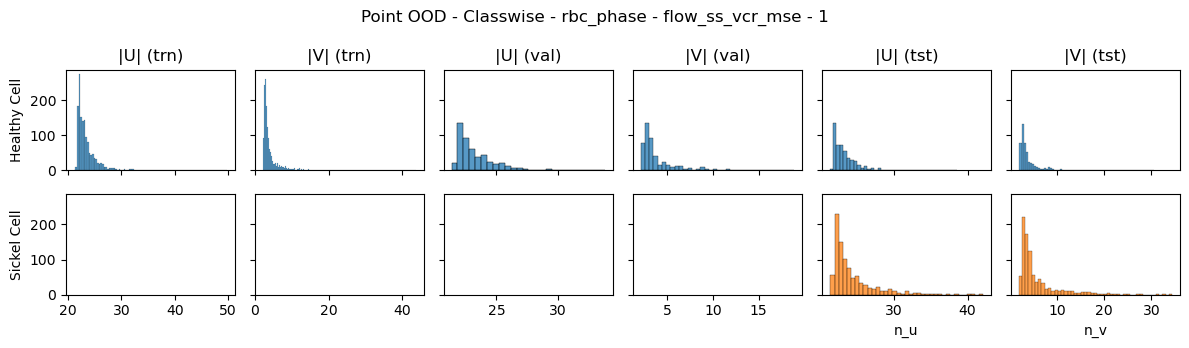

In [19]:
# pointwise
fig, axs = plt.subplots(K, 6, figsize=(6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Point OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in range(K):
    _trn = pointwise_trn[i]
    _val = pointwise_val[i]
    _tst = pointwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn, x="n_u", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn, x="n_v", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val, x="n_u", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val, x="n_v", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst, x="n_u", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst, x="n_v", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()

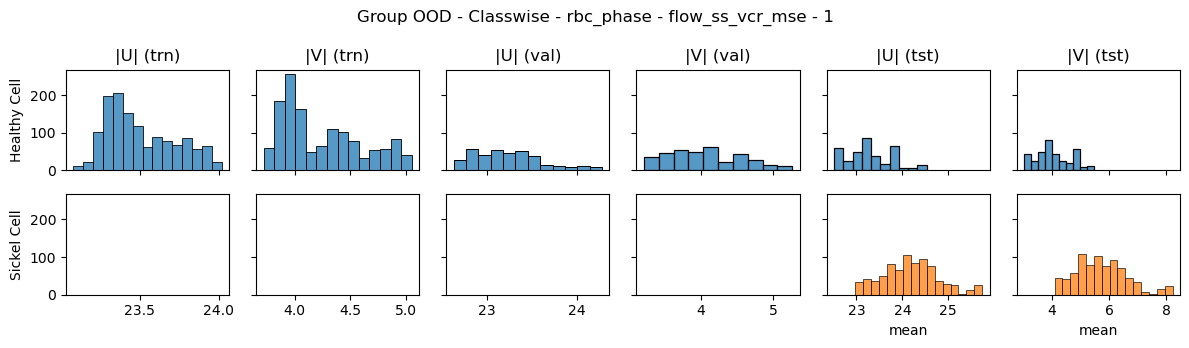

In [20]:
# groupwise
fig, axs = plt.subplots(K, 6, figsize = (6*rw, K*rh+2), sharex='col', sharey='all')
fig.suptitle(f"Group OOD - Classwise - {dataset_name} - {model_name} - {ood_str}")

for i in all_targets:
    _trn = groupwise_trn[i]
    _val = groupwise_val[i]
    _tst = groupwise_tst[i]
    _tgt = all_targets[i]
    _label = config.labels[_tgt]
    _hue = colors[i]
    (ax1, ax2, ax3, ax4, ax5, ax6) = axs[i]
    ax1.set_ylabel(_label)
    if len(_trn) > 0:
        sns.histplot(data=_trn.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax1)
        sns.histplot(data=_trn.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax2)
    if len(_val) > 0:
        sns.histplot(data=_val.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax3)
        sns.histplot(data=_val.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax4)
    if len(_tst) > 0:
        sns.histplot(data=_tst.n_u, x="mean", fill=True, legend=False, color=_hue, ax=ax5)
        sns.histplot(data=_tst.n_v, x="mean", fill=True, legend=False, color=_hue, ax=ax6)

axs[0][0].title.set_text('|U| (trn)')
axs[0][1].title.set_text('|V| (trn)')
axs[0][2].title.set_text('|U| (val)')
axs[0][3].title.set_text('|V| (val)')
axs[0][4].title.set_text('|U| (tst)')
axs[0][5].title.set_text('|V| (tst)')

plt.tight_layout()
plt.show()